# Example Notebook for plotting insitu data

In [56]:
%load_ext autoreload

%autoreload 2

import datetime as datetime
import numpy as np
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
###### overwrite initial values that we already know or can estimate more closely


overwrite = {
    "cme_longitude": {
            "maximum": 161,
            "minimum": 159
        },
    "cme_latitude": {
            "maximum": 1,
            "minimum": -1
        },
    "cme_inclination" :{
            "maximum": 6,
            "minimum": 4
        },
    "cme_diameter_1au" :{
            "maximum": 0.25,
            "minimum": 0.15
        },
    "cme_aspect_ratio": {
            "maximum": 3.1,
            "minimum": 2.9
        },
    "cme_launch_radius": {
            "distribution": "uniform",
            "maximum": 4,
            "minimum": 2
        },
    "cme_launch_velocity": {
            "maximum": 1625,
            "minimum": 1565
        },
    "t_factor": {
            "maximum": 4.1,
            "minimum": 3.9
        },
    "magnetic_field_strength_1au": {
            "maximum": 26,
            "minimum": 24
        },
    "background_drag": {
            "maximum": 0.6,
            "minimum": 0.4
        },
    "background_velocity": {
            "maximum": 505,
            "minimum": 495
        },
}

# initialize model

n = 1024 # number of runs
# start = datetime.datetime.now() # starttime of ICME
start = datetime.datetime(2022, 9, 5, 16, 0, 0)

model_obj = py3dcore_h4c.ToroidalModel(start, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [58]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()

# these can be accessed by the following

i = 1 # parameter index

model_obj.iparams_arr[:, i]

array([159.74908, 160.90143, 160.46399, ..., 159.5947 , 160.84879,
       160.94212], dtype=float32)

In [59]:
# we set a timedelta in hours and propagate each of the runs

timedelta = 32
end = start + datetime.timedelta(hours=timedelta)

model_obj.propagator(end)

# the state parameters of parameter i at that given time are then given by

model_obj.sparams_arr[:,i]

array([0.30314866, 0.29461458, 0.28915402, ..., 0.2964443 , 0.29502207,
       0.30929062], dtype=float32)

In [60]:
# an output array needs to be created beforehand, then we can simulate the magnetic field at a given position

pos = np.array([0.689,0,0]) 

outa = np.empty((n,3))
model_obj.simulator_mag(pos,out=outa)

In [61]:
outa[outa !=0]

array([], dtype=float64)

In [62]:
# dts = [datetime.datetime.now() + datetime.timedelta(hours=i) for i in range(96)]
dts = [start + datetime.timedelta(hours=i) for i in range(96)]
pos = [np.array([0.689,0,0]) for _ in dts]
outa = model_obj.simulator(dts, pos)

In [63]:
A=np.array(outa[0])
print(np.where(A!=0))
A[A==0] = np.nan

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


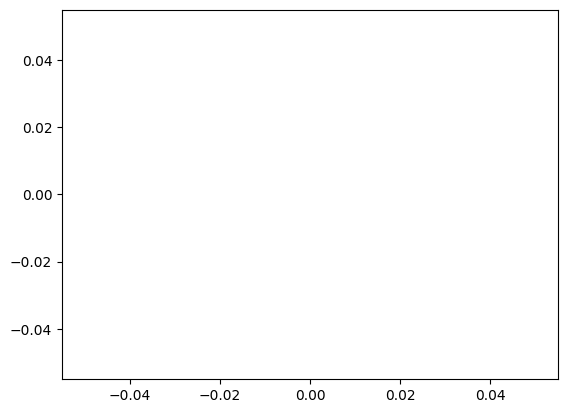

In [64]:
plt.plot(A[:, 306, :])

In [65]:
np.where(A != 0)

(array([ 0,  0,  0, ..., 95, 95, 95]),
 array([   0,    0,    0, ..., 1023, 1023, 1023]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [66]:
wf_arr=model_obj.visualize_shape(306, 30)

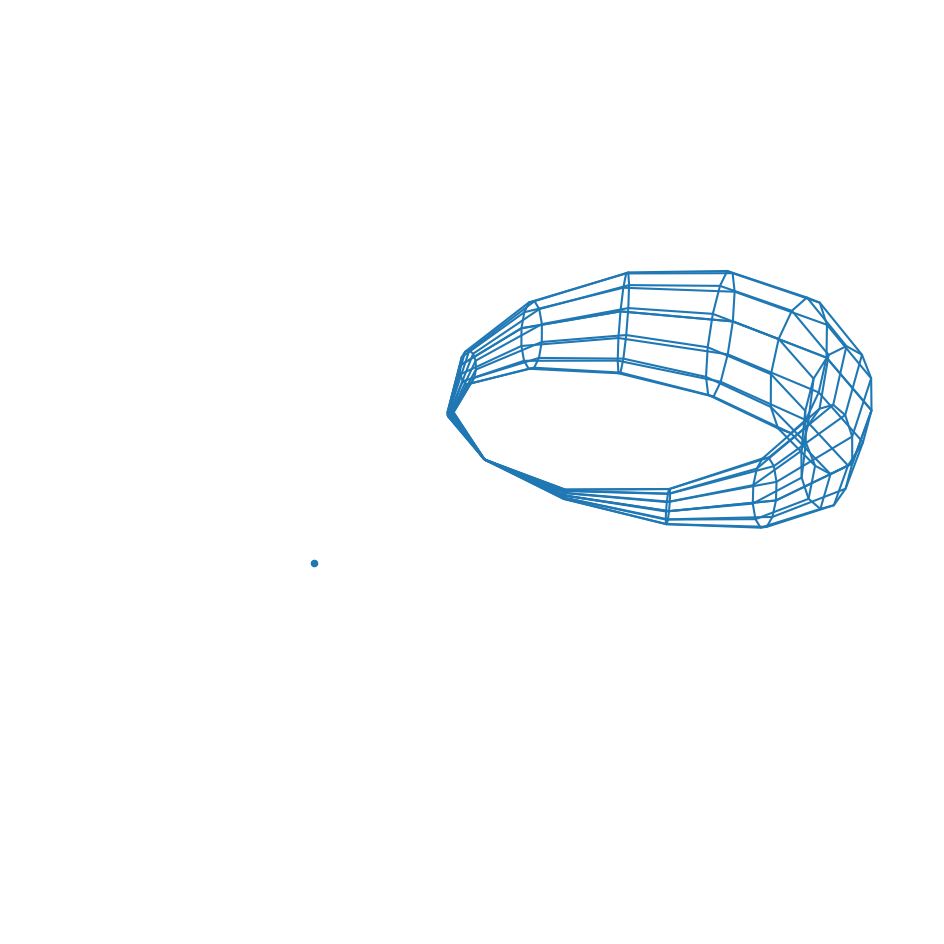

In [67]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*wf_arr.T)
ax.scatter(1,0,0)
ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=25, azim=35)